# Verify deflection from constant vorticity
from Gallet and Young (2014)

vertical vorticity
$$\zeta = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}.$$

Curvature equation
$$\chi \simeq \frac{\zeta}{c_{g}}.$$

deflection angle 
$$\theta \sim \frac{\zeta_0 l}{c_{g}}$$

See Eq.20 in Gallet and Young (2014)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import cmocean
import xarray as xa
import pytest


import sys,os
testdir = os.path.dirname(os.getcwd() + '/')
srcdir = '..'
sys.path.insert(0, os.path.abspath(os.path.join(testdir, srcdir)))

from ocean_wave_tracing import Wave_tracing

%matplotlib inline

In [2]:
ncin = xa.open_dataset('../notebooks/idealized_input.nc')

In [3]:
# SET DOMAIN

X = ncin.x.data
Y = ncin.y.data
nx = len(X)
ny = len(Y)
dx=dy=X[1]-X[0]
nb_wave_rays = 200#550#nx
T = 3000
nt = 190 # 1500
wave_period = 10 #s
X0, XN = X[0], X[-1] 
Y0, YN = Y[0], Y[-1]

In [4]:
# Solver negative vorticity
i_w_side = 'left'
theta0=0
idt0=0

wt = Wave_tracing(ncin.U_vorticity[idt0::,:,:], ncin.V_vorticity[idt0::,:,:], 
                    nx, ny, nt,T,dx,dy, nb_wave_rays=nb_wave_rays,
                    domain_X0=X0, domain_XN=XN,
                    domain_Y0=Y0, domain_YN=YN,
                     )
wt.set_initial_condition(wave_period, theta0,incoming_wave_side=i_w_side)
wt.solve()

In [5]:
# Solver positive vorticity
wt_pos_vort = Wave_tracing(-ncin.U_vorticity[idt0::,:,:], ncin.V_vorticity[idt0::,:,:], 
                    nx, ny, nt,T,dx,dy, nb_wave_rays=nb_wave_rays,
                    domain_X0=X0, domain_XN=XN,
                    domain_Y0=Y0, domain_YN=YN,
                     )
wt_pos_vort.set_initial_condition(wave_period, theta0,incoming_wave_side=i_w_side)
wt_pos_vort.solve()

In [6]:
vorticity = wt.dvdx-wt.dudy

## Quantifying the difference between analytical and numerical values

In [10]:
l = 5000-2500


In [11]:
# negative vorticity

zeta_0 = vorticity.min()
cg = wt.ray_cg[0,10]
theta_analytical = (zeta_0*l)/cg

idx=np.argmin(np.abs(wt.ray_x[0,:]-5000))
theta_wt = (2*np.pi)-wt.ray_theta[0,idx] # Theta from wave tracing

In [12]:
assert theta_analytical == pytest.approx(-theta_wt, 1e-1)

In [13]:
rel_diff = ((np.abs(theta_wt)-np.abs(theta_analytical))/np.abs(theta_analytical))*100
print("Relative difference between model and analytical: {} %".format(np.round(rel_diff,3)))

Relative difference between model and analytical: -1.162 %


In [14]:
# postive vorticity
zeta_0_pos = np.abs(vorticity.min())
theta_analytical_pos  = (zeta_0_pos*l)/cg

In [15]:
theta_wt_pos = wt_pos_vort.ray_theta[0,idx]

In [17]:
assert theta_analytical_pos == pytest.approx(theta_wt_pos, 1e-1)

In [19]:
rel_diff_pos = ((np.abs(theta_wt_pos)-np.abs(theta_analytical_pos))/np.abs(theta_analytical_pos))*100
print("Relative difference between model and analytical: {} %".format(np.round(rel_diff_pos,3)))

Relative difference between model and analytical: -1.185 %


## Plotting

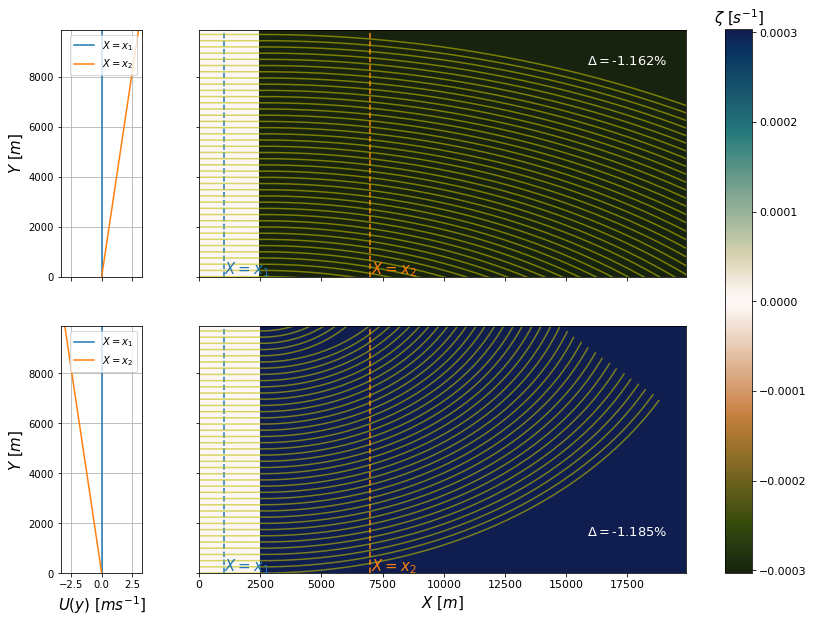

In [27]:
fs=15

idx_u0,idx_u1 =1000,7000

fig, ax = plt.subplots(nrows=2,ncols=2,sharex='col',sharey=True,figsize=(14,10),
                       gridspec_kw={'width_ratios': [1, 6]})

pc=ax[0,1].pcolormesh(wt.x,wt.y,vorticity[idt0],cmap=cmocean.cm.tarn,
                      vmin=vorticity.min(),vmax=np.abs(vorticity.min()),shading='auto')

for aax in [ax[0,1], ax[1,1]]:
    aax.axvline(idx_u0,0,ls='--',c='tab:blue')
    aax.text(idx_u0+20,100,r'$X=x_1$',c='tab:blue',fontsize=fs)
    aax.axvline(idx_u1,0,ls='--',c='tab:orange')
    aax.text(idx_u1+20,100,r'$X=x_2$',c='tab:orange',fontsize=fs)

pc1 = ax[1,1].pcolormesh(wt_pos_vort.x,wt_pos_vort.y,-vorticity[idt0],cmap=cmocean.cm.tarn,vmin=vorticity.min(),vmax=np.abs(vorticity.min()))


for i in range(0,wt.nb_wave_rays,5):
    ax[0,1].plot(wt.ray_x[i,:],wt.ray_y[i,:],'-y',alpha=0.6)
    ax[1,1].plot(wt_pos_vort.ray_x[i,:],wt_pos_vort.ray_y[i,:],'-y',alpha=0.6)
    
ax[0,1].set_xlim([X0,XN])
ax[0,1].set_ylim([Y0,YN])



ax[0,0].plot(wt.U.isel(time=idt0).sel(x=idx_u0),wt.y,c='tab:blue',label=r'$X=x_1$')
ax[0,0].plot(wt.U.isel(time=idt0).sel(x=idx_u1),wt.y,c='tab:orange',label=r'$X=x_2$')

ax[1,0].plot(wt_pos_vort.U.isel(time=idt0).sel(x=idx_u0),wt.y,c='tab:blue',label=r'$X=x_1$')
ax[1,0].plot(wt_pos_vort.U.isel(time=idt0).sel(x=idx_u1),wt.y,c='tab:orange',label=r'$X=x_2$')

for i,aax in enumerate([ax[0,0], ax[1,0]]):
    aax.legend(loc='upper right')
    aax.grid()    
    aax.set_ylabel(r'$Y~[m]$',fontsize=fs)
    if i == 1:
        aax.set_xlabel(r'$U(y)~[ms^{-1}]$',fontsize=fs)
    
ax[1,1].set_xlabel(r'$X~[m]$',fontsize=fs)
    

#fig.tight_layout()

cb0=fig.colorbar(pc,ax=ax)
cb0.ax.set_title(r'$\zeta~[s^{-1}]$',fontsize=fs)


ax[0,1].text(17500,8500,
            r'$\Delta=${}%'.format(np.round(rel_diff,3)),horizontalalignment='center',
            fontsize=fs-2,c='1')

ax[1,1].text(17500,1500,
            r'$\Delta=${}%'.format(np.round(rel_diff_pos,3)),horizontalalignment='center',
            fontsize=fs-2,c='1')


ax[0,1].tick_params(axis='both',labelsize=fs-4)
ax[1,1].tick_params(axis='both',labelsize=fs-4)
cb0.ax.tick_params(labelsize=fs-4)
#cb1.ax.tick_params(labelsize=fs-4)
fig.savefig('wave_deflection.png',dpi=125)

## Summary
The wave ray delfection difference between negative and positive vorticity $\zeta$ is due to the advection of the current, which is also incorporated in the relative differences together with numerical noise. 